<table style="width:100%">
  <tr>
    <td><center style="font-size:300%;">Séries Temporais</center></td>
    <td><img src="https://logodownload.org/wp-content/uploads/2015/02/puc-rio-logo.gif" width="100"/></td> 
  </tr>    
</table>

Msc. Cristian Muñoz V.

## Exemplo: Previsão do consumo de eletricidade

Neste exemplo, vamos a realizar uma previsão de consumo de eletricidade de uma empresa.
O conjunto de dados utilizado é `Electricity Load Diagrams` de [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014), e contem informação de consumo de 370 clientes, com dados tomados em intervalos de 15 minutos em um período de 4 anos desde 2011 até 2014. Foi selecionado o cliente # 250 para nosso exemplo.

## Pré-processamento

Como podemos observar, existe claramente uma tendencia periodica diaria. Asim, o problema é um bom candidato para nosso modelo. Também, baseado em nosso observação, a `BATCH_SIZE` de 96 (# de dados cada 15 minutos para 24 horas) é apropiado. Agora, para apresentar os dois modelos, primeiro vamos importar as bibliotecas e classes necessarias:

In [1]:
%%bash

rm -rf LD_250.txt
wget -O LD_250.txt https://raw.githubusercontent.com/crismunoz/DeepLearningExamples/master/week2/resources/LD_250.txt

--2019-04-27 03:11:18--  https://raw.githubusercontent.com/crismunoz/DeepLearningExamples/master/week2/resources/LD_250.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3506400 (3.3M) [text/plain]
Saving to: ‘LD_250.txt’

     0K .......... .......... .......... .......... ..........  1% 3.45M 1s
    50K .......... .......... .......... .......... ..........  2% 6.12M 1s
   100K .......... .......... .......... .......... ..........  4% 49.5M 1s
   150K .......... .......... .......... .......... ..........  5%  158M 0s
   200K .......... .......... .......... .......... ..........  7% 7.80M 0s
   250K .......... .......... .......... .......... ..........  8%  120M 0s
   300K .......... .......... .......... .......... .......... 10% 56.6M 0s
   350K ........

In [2]:
from keras import Model,Input
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import os

Using TensorFlow backend.


Abrimos o arquivo com a serie temporal:

In [0]:
def load_data(np_file):
    data = np.loadtxt(np_file).reshape(-1,1)
    # Escala os valores entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0,1), copy=False)
    data = scaler.fit_transform(data)
    return data.squeeze()

Vamos a visualizar uma parte dos dados:

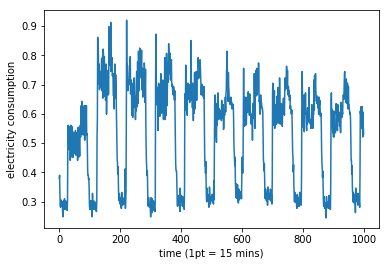

In [4]:
serie = load_data("LD_250.txt")
num_pontos = 1000
plt.plot(range(num_pontos), serie[0:num_pontos])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()

Em cada batch, o modelo pega uma sequencia de 15 minutos e preveera o seguiente.  A dimensão da sequencia de entrada é dada pela variavel `num_timesteps` no código. Baseados em alguns experimentos realizados, obtimos o valor para `num_timesteps` de 20. Então, cada fila tem uma sequencia de dimensão 20 e a saida de dimensão 1. O seguinte passo reordena as matrizes $x$ e $y$ em tensor de entrara de dimensão `(None,4)` e `(None,1)`. Finalmente, redimensionamos o tensor de entrada $x$ para 3 dimensões que se precisa para a entrada da rede. Logo, dividimos nossos dados de treinamento e teste (70-30). Como trabalhamos com series temporais, escolhems o punto de corte e dividimos a data em 2 partes, e não utilizar a função `train_test_split`, que embaralha os dados.

In [0]:
def get_serie_train_test(serie, num_timesteps, per_train, batch_size):

    X = np.array([serie[i:][:num_timesteps] for i in range(len(serie) - num_timesteps - 1)])
    Y = np.array([serie[i:][num_timesteps+1] for i in range(len(serie) - num_timesteps - 1)])
    
    X = np.expand_dims(X,2)
    # split into training and test sets
    train_len = int(per_train*len(serie))
    
    Xtrain, Ytrain = X[:train_len], Y[:train_len]
    Xtest,  Ytest = X[train_len:], Y[train_len:]
    
    crop_train = (Xtrain.shape[0]%batch_size)*batch_size
    crop_test = (Xtest.shape[0]%batch_size)*batch_size
    Xtrain = Xtrain[:crop_train]
    Ytrain = Ytrain[:crop_train]
    Xtest = Xtest[:crop_test]
    Ytest = Ytest[:crop_test]
    
    print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
    
    return Xtrain, Xtest, Ytrain, Ytest

In [6]:
num_timesteps=20
batch_size = 96
Xtrain, Xtest, Ytrain, Ytest = get_serie_train_test(serie = serie, 
                                                    num_timesteps = num_timesteps,
                                                    batch_size = batch_size,
                                                    per_train = 0.7)

(6432, 20, 1) (768, 20, 1) (6432,) (768,)


## Criação do Modelo
O primeiro modelo será sem armzenar o estado ao longo do treinamento. Configuramos o `batch_size` e `num_timesteps`, como foi detalhado anteriormente. A dimensão de nossa LSTM é dada pela `hidden_size`. Neste caso só configuramos com 10 pois só queremos comparar 2 redes.

In [7]:
hidden_size = 10
epochs = 5

input  = Input(batch_shape=(batch_size, num_timesteps, 1))
x      = LSTM(hidden_size, stateful=True, return_sequences=False)(input)
output = Dense(1)(x)

model = Model(input=input, output=output)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (96, 20, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (96, 10)                  480       
_________________________________________________________________
dense_1 (Dense)              (96, 1)                   11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


# Treinamento

In [8]:
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

for i in range(epochs):
    print("Epoch {:d}/{:d}".format(i+1, epochs))
    model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=1,
              validation_data=(Xtest, Ytest),
              shuffle=False, verbose=1)
    model.reset_states()

(6432, 20, 1) (768, 20, 1) (6432,) (768,)
Epoch 1/5
Instructions for updating:
Use tf.cast instead.
Train on 6432 samples, validate on 768 samples
Epoch 1/1
6432/6432 [==============================] - 1s 140us/step - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/5
Train on 6432 samples, validate on 768 samples
Epoch 1/1
6432/6432 [==============================] - 0s 73us/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 3/5
Train on 6432 samples, validate on 768 samples
Epoch 1/1
6432/6432 [==============================] - 0s 74us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/5
Train on 6432 samples, validate on 768 samples
Epoch 1/1
6432/6432 [==============================] - 0s 77us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 5/5
Train on 6432 s

In [9]:
score, _ = model.evaluate(Xtest, Ytest, batch_size=batch_size, verbose=0)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))


MSE: 0.008, RMSE: 0.091


# Previsão

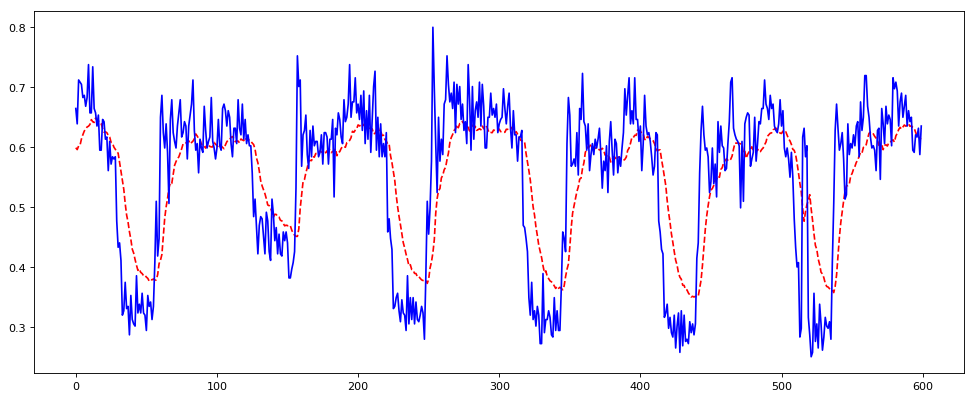

In [10]:
num_pontos=600
output = model.predict(Xtest, batch_size=batch_size)
steps = range(num_pontos)
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(steps,output[-num_pontos:],'r--', 
         steps,Ytest[-num_pontos:], 'b' )
plt.show()